In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import glob

In [24]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

# pulling behavior analysis
## load behavioral results

In [25]:
## claim the list of sessions

animal1_name = "Koala"
animal2_name = "Vermelho"

session_dates = ["20230607","20230608","20230609","20230613","20230614","20230615","20230616","20230619",
                 "20230620","20230621","20230622","20230623","20230626","20230627","20230628","20230629",
                 "20230801","20230802","20230803","20230804"
                 ]
# session_dates = ["20230602","20230608","20230609","20230613","20230614"]


nsessions = np.shape(session_dates)[0]


In [26]:
# load session behavioral results

cumulative_pulls_animal1 = {}
cumulative_pulls_animal2 = {}

cumulative_pulls_trialnum_animal1 = {}
cumulative_pulls_trialnum_animal2 = {}

RT_pulls_animal1_all = {}
RT_pulls_animal2_all = {}
RT_pulls_anyanimal_all = {}

session_dates_forplot = []

#tasktypes_all_dates = np.zeros((nsessions,1))
tasktypes_all_dates = []

time_limits = 15*60 # limit the analysis to a time window: xx*60s

for ii in np.arange(0,nsessions,1):

    date_tgt = session_dates[ii]
    
    bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_joystick_task/"+date_tgt+"_"+animal1_name+"_"+animal2_name+"/"
    try:
        trial_record_json = glob.glob(bhv_data_path+date_tgt+"_"+animal1_name+"_"+animal2_name+"_TrialRecord" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path+date_tgt+"_"+animal1_name+"_"+animal2_name+"_bhv_data" + "*.json")
        session_info_json = glob.glob(bhv_data_path+date_tgt+"_"+animal1_name+"_"+animal2_name+"_session_info" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
    except:
        trial_record_json = glob.glob(bhv_data_path+date_tgt+"_"+animal2_name+"_"+animal1_name+"_TrialRecord" + "*.json")
        bhv_data_json = glob.glob(bhv_data_path+date_tgt+"_"+animal2_name+"_"+animal1_name+"_bhv_data" + "*.json")
        session_info_json = glob.glob(bhv_data_path+date_tgt+"_"+animal2_name+"_"+animal1_name+"_session_info" + "*.json")
        #
        trial_record = pd.read_json(trial_record_json[0])
        bhv_data = pd.read_json(bhv_data_json[0])
        session_info = pd.read_json(session_info_json[0])
        
    #
    animal1 = session_info['animal1_name'][0].lower()
    animal2 = session_info['animal2_name'][0].lower()
    #
    # clean up the trial_record
    warnings.filterwarnings('ignore')
    trial_record_clean = trial_record.reset_index(drop = True)
    #
    # change bhv_data time to the absolute time
    time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
    for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        ind = bhv_data["trial_number"]==itrial+1
        new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
        time_points_new["time_points_new"][ind] = new_time_itrial
    ind = bhv_data["trial_number"]>np.max(trial_record_clean['trial_number'])
    bhv_data["time_points"] = time_points_new["time_points_new"]
    bhv_data = bhv_data.drop(np.where(ind)[0])
    
    ind_good = bhv_data['time_points']<time_limits
    bhv_data = bhv_data[ind_good]
    
    tasktype_pertrial = trial_record_clean['task_type']
    
    # reaction time
    anyanimal_pulltime = bhv_data['time_points'][bhv_data['behavior_events']==0]
    trialend_time = bhv_data['time_points'][bhv_data['behavior_events']==9]
    RT_pull = anyanimal_pulltime[1:].reset_index(drop=True) - trialend_time[:-1].reset_index(drop=True)
    # remove the interval if it's > 30 
    RT_pull[RT_pull>30]=np.nan
    
    #
    # if the whole session only has one task type
    if len(np.unique(tasktype_pertrial))==1:
        
        # separate animal1 and 2
        animal1_pulltime = bhv_data["time_points"][bhv_data["behavior_events"]==1].reset_index(drop=True)
        animal2_pulltime = bhv_data["time_points"][bhv_data["behavior_events"]==2].reset_index(drop=True)
    
        animal1_pulltime_trialnum = bhv_data["trial_number"][bhv_data["behavior_events"]==1].reset_index(drop=True)
        animal2_pulltime_trialnum = bhv_data["trial_number"][bhv_data["behavior_events"]==2].reset_index(drop=True)
        #
        #
        RT_pulls_animal1 = RT_pull[animal1_pulltime_trialnum[animal1_pulltime_trialnum>1]-2].reset_index(drop=True)
        RT_pulls_animal2 = RT_pull[animal2_pulltime_trialnum[animal2_pulltime_trialnum>1]-2].reset_index(drop=True)
    
        # summary    
        if (animal1 == animal1_name.lower()):
            cumulative_pulls_animal1[date_tgt] = animal1_pulltime
            cumulative_pulls_animal2[date_tgt] = animal2_pulltime
            cumulative_pulls_trialnum_animal1[date_tgt] = animal1_pulltime_trialnum
            cumulative_pulls_trialnum_animal2[date_tgt] = animal2_pulltime_trialnum
            RT_pulls_anyanimal_all[date_tgt] = RT_pull
            RT_pulls_animal1_all[date_tgt] = RT_pulls_animal1
            RT_pulls_animal2_all[date_tgt] = RT_pulls_animal2

        elif (animal1 == animal2_name.lower()):
            cumulative_pulls_animal1[date_tgt] = animal2_pulltime
            cumulative_pulls_animal2[date_tgt] = animal1_pulltime
            cumulative_pulls_trialnum_animal1[date_tgt] = animal2_pulltime_trialnum
            cumulative_pulls_trialnum_animal2[date_tgt] = animal1_pulltime_trialnum
            RT_pulls_anyanimal_all[date_tgt] = RT_pull
            RT_pulls_animal1_all[date_tgt] = RT_pulls_animal2
            RT_pulls_animal2_all[date_tgt] = RT_pulls_animal1

        try:
            tasktype = session_info["task_type"][0]
        except:
            tasktype = 0
        if len(tasktypes_all_dates)==0:
            tasktypes_all_dates = [tasktype]
            session_dates_forplot = [date_tgt]
        else:
            tasktypes_all_dates = np.vstack((tasktypes_all_dates,tasktype))
            session_dates_forplot.append(date_tgt)
        
    # in the task type alternating condition    
    elif len(np.unique(tasktype_pertrial))>1:
        
        ntasktype_alt = len(np.unique(tasktype_pertrial))
        
        for ialt in np.arange(0,ntasktype_alt,1):
        
            ind_itask = tasktype_pertrial == np.unique(tasktype_pertrial)[ialt]
            trialnum_itask = trial_record_clean['trial_number'][ind_itask].reset_index(drop=True)
            bhv_data_itask = bhv_data[np.isin(bhv_data["trial_number"],trialnum_itask)]
            
            if ialt == 0: 
                date_tgt_itask = date_tgt+"_task1"
            elif ialt == 1:
                date_tgt_itask = date_tgt+"_task2"
        
            # separate animal1 and 2
            animal1_pulltime = bhv_data_itask["time_points"][bhv_data_itask["behavior_events"]==1].reset_index(drop=True)
            animal2_pulltime = bhv_data_itask["time_points"][bhv_data_itask["behavior_events"]==2].reset_index(drop=True)

            animal1_pulltime_trialnum = bhv_data_itask["trial_number"][bhv_data_itask["behavior_events"]==1].reset_index(drop=True)
            animal2_pulltime_trialnum = bhv_data_itask["trial_number"][bhv_data_itask["behavior_events"]==2].reset_index(drop=True)
            #
            #
            RT_pulls_animal1 = RT_pull[animal1_pulltime_trialnum[animal1_pulltime_trialnum>1]-2].reset_index(drop=True)
            RT_pulls_animal2 = RT_pull[animal2_pulltime_trialnum[animal2_pulltime_trialnum>1]-2].reset_index(drop=True)

            # summary
            if (animal1 == animal1_name.lower()):
                cumulative_pulls_animal1[date_tgt_itask] = animal1_pulltime
                cumulative_pulls_animal2[date_tgt_itask] = animal2_pulltime
                cumulative_pulls_trialnum_animal1[date_tgt_itask] = animal1_pulltime_trialnum
                cumulative_pulls_trialnum_animal2[date_tgt_itask] = animal2_pulltime_trialnum
                RT_pulls_anyanimal_all[date_tgt_itask] = RT_pull
                RT_pulls_animal1_all[date_tgt_itask] = RT_pulls_animal1
                RT_pulls_animal2_all[date_tgt_itask] = RT_pulls_animal2

            elif (animal1 == animal2_name.lower()):
                cumulative_pulls_animal1[date_tgt_itask] = animal2_pulltime
                cumulative_pulls_animal2[date_tgt_itask] = animal1_pulltime
                cumulative_pulls_trialnum_animal1[date_tgt_itask] = animal2_pulltime_trialnum
                cumulative_pulls_trialnum_animal2[date_tgt_itask] = animal1_pulltime_trialnum
                RT_pulls_anyanimal_all[date_tgt_itask] = RT_pull
                RT_pulls_animal1_all[date_tgt_itask] = RT_pulls_animal2
                RT_pulls_animal2_all[date_tgt_itask] = RT_pulls_animal1

            tasktype = np.unique(tasktype_pertrial)[ialt]

            if len(tasktypes_all_dates)==0:
                tasktypes_all_dates = [tasktype]
                session_dates_forplot = [date_tgt_itask]
            else:
                tasktypes_all_dates = np.vstack((tasktypes_all_dates,tasktype))
                session_dates_forplot.append(date_tgt_itask)
            
            
nsessions = np.shape(session_dates_forplot)[0]


In [27]:
ii

19

## plot behavioral results 
### cumulative pulling results

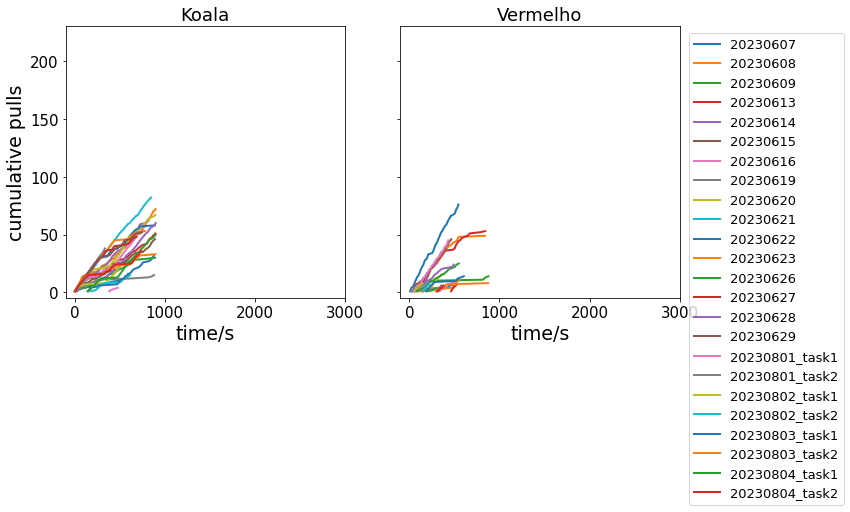

In [28]:
# plot for self condition
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(11)
#
for ii in np.arange(0,nsessions,1):
    xxx = cumulative_pulls_animal1[session_dates_forplot[ii]]
    yyy = np.arange(1,np.shape(cumulative_pulls_animal1[session_dates_forplot[ii]])[0]+1,1)
    axs[0].plot(xxx,yyy,linewidth=2)
    xxx = cumulative_pulls_animal2[session_dates_forplot[ii]]
    yyy = np.arange(1,np.shape(cumulative_pulls_animal2[session_dates_forplot[ii]])[0]+1,1)
    axs[1].plot(xxx,yyy,linewidth=2)
axs[0].set_title(animal1_name+"",fontsize = 18)
axs[0].set_ylim([-5,230])
axs[0].set_xlim([-100,3000])
axs[0].set_xlabel("time/s",fontsize = 19)
axs[0].set_ylabel("cumulative pulls",fontsize = 19)
axs[0].tick_params(labelsize = 15)
axs[1].set_title(animal2_name+"",fontsize = 18)    
axs[1].set_ylim([-5,230])
axs[1].set_xlim([-100,3000])
axs[1].set_xlabel("time/s",fontsize = 19)
axs[1].set_yticklabels("")
axs[1].tick_params(labelsize = 15)
axs[1].legend(labels=session_dates_forplot, fontsize = 13,bbox_to_anchor=(1.01, 1), loc='upper left')
#plt.savefig("cumulative_pulling.png")

### inter-pull interval within animal

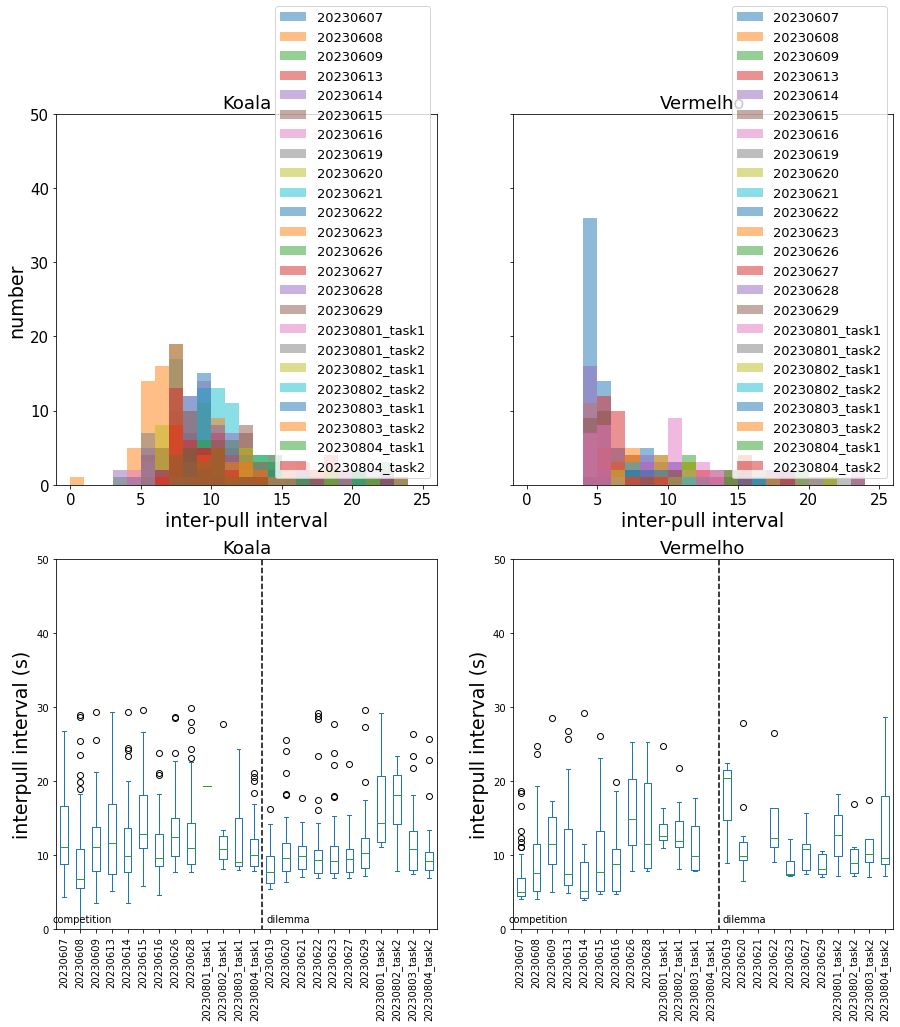

In [29]:
# animal1 inter-pull interval
fig, axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

## histogram

#
mean_interpull_interval_animal1 = []
interpull_interval_sum_animal1 = {}
#
for ii in np.arange(0,nsessions,1):
    interpull_interval = []
    xxx = cumulative_pulls_animal1[session_dates_forplot[ii]]
    next_pull = xxx[np.arange(1,np.shape(xxx)[0],1)].reset_index(drop=True) 
    first_pull = xxx[np.arange(0,np.shape(xxx)[0]-1,1)].reset_index(drop=True)
    interpull_interval = next_pull - first_pull
    interpull_interval = interpull_interval[interpull_interval<(np.mean(interpull_interval)+3*np.std(interpull_interval))]
    #
    # remove the interval if it's > 30 
    interpull_interval[interpull_interval>30]=np.nan
    #
    interpull_interval_sum_animal1[ii] = interpull_interval
    #
    axs[0,0].hist(interpull_interval,alpha=0.5, bins=np.arange(0,25,1))
    #
    mean_interpull_interval_animal1.append(np.mean(interpull_interval))
#    
interpull_interval_sum_animal1=(pd.DataFrame(interpull_interval_sum_animal1))
    
#
mean_interpull_interval_animal2 = []
interpull_interval_sum_animal2 = {}
#
for ii in np.arange(0,nsessions,1):
    interpull_interval = []
    xxx = cumulative_pulls_animal2[session_dates_forplot[ii]]
    next_pull = xxx[np.arange(1,np.shape(xxx)[0],1)].reset_index(drop=True) 
    first_pull = xxx[np.arange(0,np.shape(xxx)[0]-1,1)].reset_index(drop=True)
    interpull_interval = next_pull - first_pull
    interpull_interval = interpull_interval[interpull_interval<(np.mean(interpull_interval)+3*np.std(interpull_interval))]
    #
    # remove the interval if it's > 30 
    interpull_interval[interpull_interval>30]=np.nan
    #
    interpull_interval_sum_animal2[ii] = interpull_interval
    #
    axs[0,1].hist(interpull_interval,alpha=0.5, bins=np.arange(0,25,1))
    #
    mean_interpull_interval_animal2.append(np.mean(interpull_interval))
#
interpull_interval_sum_animal2=(pd.DataFrame(interpull_interval_sum_animal2))

axs[0,0].set_title(animal1_name,fontsize = 18)
axs[0,0].set_xlabel("inter-pull interval",fontsize = 19)
axs[0,0].set_ylabel("number",fontsize = 19)
axs[0,0].set_xlim([-1,26])
axs[0,0].set_ylim([0,50])
axs[0,0].tick_params(labelsize = 15)
axs[0,0].legend(labels=session_dates_forplot, fontsize = 13)
axs[0,1].set_title(animal2_name,fontsize = 18)
axs[0,1].set_xlabel("inter-pull interval",fontsize = 19)
axs[0,1].set_ylabel("")
axs[0,1].set_xlim([-1,26])
axs[0,1].set_ylim([0,50])
axs[0,1].set_yticklabels("")
axs[0,1].tick_params(labelsize = 15)
axs[0,1].legend(labels=session_dates_forplot, fontsize = 13)


## box plot
#
# sort the data based on task type and dates
tasktypes_forsort = tasktypes_all_dates
sorting_df = pd.DataFrame({'dates': session_dates_forplot, 'tasktypes': tasktypes_forsort.ravel()}, columns=['dates', 'tasktypes'])
sorting_df = sorting_df.sort_values(by=['tasktypes','dates'], ascending = [True, True])
#
interpull_interval_sum_animal1[sorting_df.index].plot(kind = 'box',ax=axs[1,0])
interpull_interval_sum_animal2[sorting_df.index].plot(kind = 'box',ax=axs[1,1])
axs[1,0].set_title(animal1_name,fontsize = 18)
axs[1,0].set_ylabel("interpull interval (s)",fontsize = 19)
axs[1,0].set_ylim([0,50])
axs[1,0].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,0].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10)
axs[1,1].set_title(animal2_name,fontsize = 18)
axs[1,1].set_ylabel("interpull interval (s)",fontsize = 19)
axs[1,1].set_ylim([0,50])
axs[1,1].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,1].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
#
tasktypes = ['competition','dilemma']
taskswitches = np.where(np.array(sorting_df['tasktypes'])[1:]-np.array(sorting_df['tasktypes'])[:-1]!=0)[0]+1.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1,0].plot([taskswitch,taskswitch],[-0.15,50],'k--')
    axs[1,1].plot([taskswitch,taskswitch],[-0.15,50],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1,0].text(taskswitch+0.25,1,tasktypes[itaskswitch],fontsize=10)
    axs[1,1].text(taskswitch+0.25,1,tasktypes[itaskswitch],fontsize=10)
#

### interpull interval - across animals

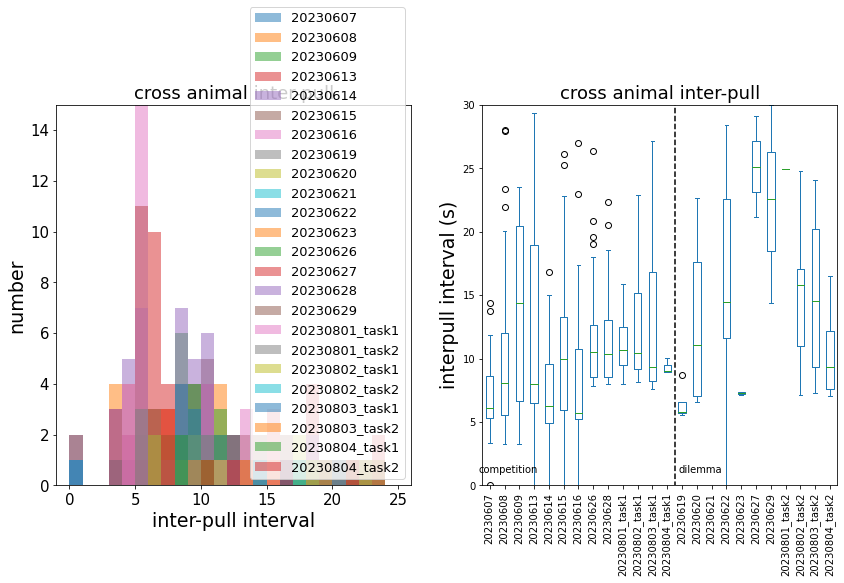

In [30]:
# animal1 inter-pull interval
fig, axs = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(14)

## histogram

#
mean_crosspull_interval = []
crosspull_interval_sum = {}
#
for ii in np.arange(0,nsessions,1):
    
    xxx1 = cumulative_pulls_animal1[session_dates_forplot[ii]]
    xxx2 = cumulative_pulls_animal2[session_dates_forplot[ii]]
    
    npulls_ani1 = np.shape(xxx1)[0]
    npulls_ani2 = np.shape(xxx2)[0]
    
    if (npulls_ani1 < npulls_ani2):
        crosspull_interval = np.empty((1,npulls_ani1))
        crosspull_interval[:] = np.nan
        for ipull in np.arange(0,npulls_ani1,1):
            crosspull_interval[0][ipull] = np.nanmin(np.abs(xxx2-xxx1[ipull]))
            # remove the interval if it's > 30
            if np.nanmin(np.abs(xxx2-xxx1[ipull]))>30:
                crosspull_interval[0][ipull] = np.nan
            
    else:
        crosspull_interval = np.empty((1,npulls_ani2))
        crosspull_interval[:] = np.nan
        for ipull in np.arange(0,npulls_ani2,1):
            crosspull_interval[0][ipull] = np.nanmin(np.abs(xxx1-xxx2[ipull]))
            if np.nanmin(np.abs(xxx1-xxx2[ipull]))>30:
                crosspull_interval[0][ipull] = np.nan
    
    crosspull_interval_sum [ii] = pd.Series(crosspull_interval[0])
    #
    axs[0].hist(crosspull_interval[0],alpha=0.5, bins=np.arange(0,25,1))
    #
    mean_crosspull_interval.append(np.mean(crosspull_interval))
#
crosspull_interval_sum = pd.DataFrame(crosspull_interval_sum)
#
axs[0].set_title('cross animal inter-pull',fontsize = 18)
axs[0].set_xlabel("inter-pull interval",fontsize = 19)
axs[0].set_ylabel("number",fontsize = 19)
axs[0].set_xlim([-1,26])
axs[0].set_ylim([0,15])
axs[0].tick_params(labelsize = 15)
axs[0].legend(labels=session_dates_forplot, fontsize = 13)    
    
    
#
## box plot
#
# sort the data based on task type and dates
tasktypes_forsort = tasktypes_all_dates
sorting_df = pd.DataFrame({'dates': session_dates_forplot, 'tasktypes': tasktypes_forsort.ravel()}, columns=['dates', 'tasktypes'])
sorting_df = sorting_df.sort_values(by=['tasktypes','dates'], ascending = [True, True])
#
crosspull_interval_sum[sorting_df.index].plot(kind = 'box',ax=axs[1])
axs[1].set_title('cross animal inter-pull',fontsize = 18)
axs[1].set_ylabel("interpull interval (s)",fontsize = 19)
axs[1].set_ylim([0,30])
axs[1].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
#
tasktypes = ['competition','dilemma']
taskswitches = np.where(np.array(sorting_df['tasktypes'])[1:]-np.array(sorting_df['tasktypes'])[:-1]!=0)[0]+1.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1].plot([taskswitch,taskswitch],[-0.15,30],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1].text(taskswitch+0.25,1,tasktypes[itaskswitch],fontsize=10)
#

### Alternative pull percentage

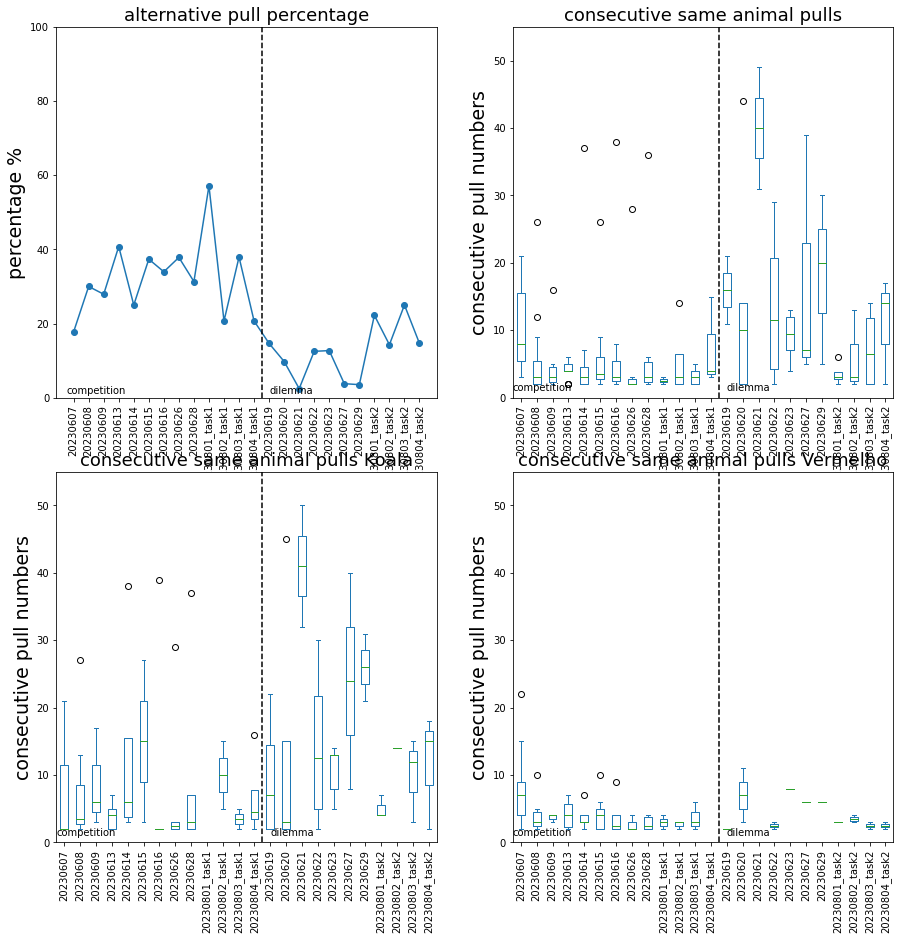

In [31]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

#
alterpull_perc = np.zeros((1,nsessions))
continous_pull_either = {}
continous_pull_A1 = {}
continous_pull_A2 = {}
#
# sort the data based on task type and dates
tasktypes_forsort = tasktypes_all_dates
sorting_df = pd.DataFrame({'dates': session_dates_forplot, 'tasktypes': tasktypes_forsort.ravel()}, columns=['dates', 'tasktypes'])
sorting_df = sorting_df.sort_values(by=['tasktypes','dates'], ascending = [True, True])
#
for ii in np.arange(0,nsessions,1):
    xxx1 = cumulative_pulls_animal1[session_dates_forplot[ii]]
    xxx2 = cumulative_pulls_animal2[session_dates_forplot[ii]]
    #
    df_animal1=pd.DataFrame([pd.Series(1*np.ones((1,np.shape(xxx1)[0]))[0],name='animal'),xxx1]).T
    df_animal2=pd.DataFrame([pd.Series(2*np.ones((1,np.shape(xxx2)[0]))[0],name='animal'),xxx2]).T
    df_animal = pd.concat([df_animal1,df_animal2])
    df_animal = df_animal.sort_values('time_points')
    #
    animal_dif = np.array(df_animal['animal'][1:])-np.array(df_animal['animal'][0:-1])
    #
    all_pull_num = np.shape(animal_dif)[0]
    alte_pull_num = np.sum(animal_dif!=0)
    alterpull_perc[0][ii] = (alte_pull_num/all_pull_num)*100
    
    # find the length of the continuous pull from one animal
    continous_pull_either[ii] = pd.Series(zero_runs(animal_dif)[:,1]-zero_runs(animal_dif)[:,0])
    continous_pull_either[ii][continous_pull_either[ii]<=1]=np.nan
    continous_pull_A1[ii] = pd.Series(zero_runs(np.array(df_animal['animal']-1))[:,1]-
                                      zero_runs(np.array(df_animal['animal']-1))[:,0])
    continous_pull_A1[ii][continous_pull_A1[ii]<=1]=np.nan
    continous_pull_A2[ii] = pd.Series(zero_runs(np.array(df_animal['animal']-2))[:,1]-
                                      zero_runs(np.array(df_animal['animal']-2))[:,0])
    continous_pull_A2[ii][continous_pull_A2[ii]<=1]=np.nan
    
continous_pull_either = pd.DataFrame(continous_pull_either)
continous_pull_A1 = pd.DataFrame(continous_pull_A1)
continous_pull_A2 = pd.DataFrame(continous_pull_A2)

    
# alternatie pull percentage
axs[0,0].plot(np.arange(0,nsessions,1),alterpull_perc[0][sorting_df.index],'o-')
axs[0,0].set_title('alternative pull percentage',fontsize = 18)
axs[0,0].set_xticks(np.arange(0, nsessions,1)) 
axs[0,0].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10)
axs[0,0].set_ylabel("percentage %",fontsize = 19)
axs[0,0].set_ylim([0,100])
axs[0,0].tick_params(labelsize = 10);

# continuous same animal pull distribution
continous_pull_either[sorting_df.index].plot(kind = 'box',ax=axs[0,1])
axs[0,1].set_title('consecutive same animal pulls',fontsize = 18)
axs[0,1].set_ylabel("consecutive pull numbers",fontsize = 19)
axs[0,1].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[0,1].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
axs[0,1].set_ylim([0,55])

# continuous same animal pull distribution - animal 1
continous_pull_A1[sorting_df.index].plot(kind = 'box',ax=axs[1,0])
axs[1,0].set_title('consecutive same animal pulls '+animal1_name,fontsize = 18)
axs[1,0].set_ylabel("consecutive pull numbers",fontsize = 19)
axs[1,0].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,0].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
axs[1,0].set_ylim([0,55])

# continuous same animal pull distribution - animal 2
continous_pull_A2[sorting_df.index].plot(kind = 'box',ax=axs[1,1])
axs[1,1].set_title('consecutive same animal pulls '+animal2_name,fontsize = 18)
axs[1,1].set_ylabel("consecutive pull numbers",fontsize = 19)
axs[1,1].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,1].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
axs[1,1].set_ylim([0,55])

#
tasktypes = ['competition','dilemma']
taskswitches = np.where(np.array(sorting_df['tasktypes'])[1:]-np.array(sorting_df['tasktypes'])[:-1]!=0)[0]+1.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[0,0].plot([taskswitch-1,taskswitch-1],[0,100],'k--')
    axs[0,1].plot([taskswitch,taskswitch],[0,55],'k--')
    axs[1,0].plot([taskswitch,taskswitch],[0,55],'k--')
    axs[1,1].plot([taskswitch,taskswitch],[0,55],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[0,0].text(taskswitch-0.5,1,tasktypes[itaskswitch],fontsize=10)
    axs[0,1].text(taskswitch+0.5,1,tasktypes[itaskswitch],fontsize=10)
    axs[1,0].text(taskswitch+0.5,1,tasktypes[itaskswitch],fontsize=10)
    axs[1,1].text(taskswitch+0.5,1,tasktypes[itaskswitch],fontsize=10)
#

### Reaction Time within animal

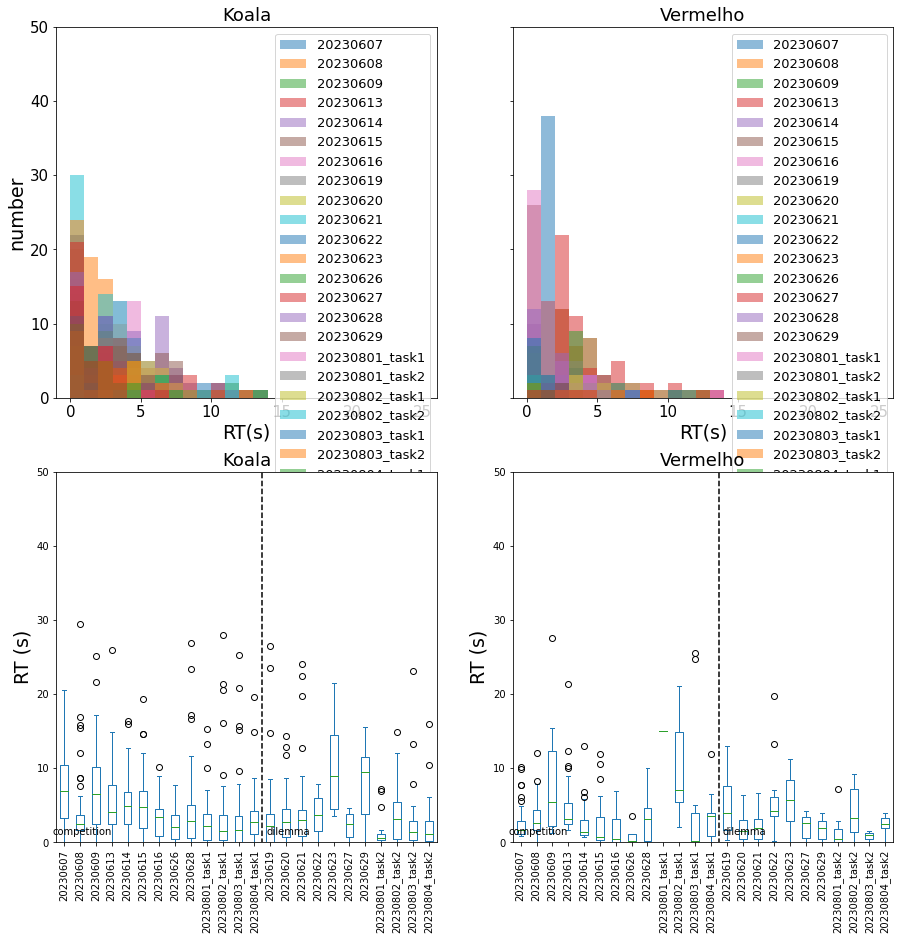

In [32]:
# pull RT 
fig, axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

## histogram
mean_RT_pulls_animal1 = []
for ii in np.arange(0,nsessions,1):
    #
    axs[0,0].hist(RT_pulls_animal1_all[session_dates_forplot[ii]],alpha=0.5, bins=np.arange(0,15,1))
    #
    mean_RT_pulls_animal1.append(np.mean(RT_pulls_animal1_all[session_dates_forplot[ii]]))
#    
RT_pulls_animal1_all=(pd.DataFrame(RT_pulls_animal1_all))
    
#
mean_RT_pulls_animal2 = []
for ii in np.arange(0,nsessions,1):
    #
    axs[0,1].hist(RT_pulls_animal2_all[session_dates_forplot[ii]],alpha=0.5, bins=np.arange(0,15,1))
    #
    mean_RT_pulls_animal2.append(np.mean(RT_pulls_animal2_all[session_dates_forplot[ii]]))
#    
RT_pulls_animal2_all=(pd.DataFrame(RT_pulls_animal2_all))

axs[0,0].set_title(animal1_name,fontsize = 18)
axs[0,0].set_xlabel("RT(s)",fontsize = 19)
axs[0,0].set_ylabel("number",fontsize = 19)
axs[0,0].set_xlim([-1,26])
axs[0,0].set_ylim([0,50])
axs[0,0].tick_params(labelsize = 15)
axs[0,0].legend(labels=session_dates_forplot, fontsize = 13)
axs[0,1].set_title(animal2_name,fontsize = 18)
axs[0,1].set_xlabel("RT(s)",fontsize = 19)
axs[0,1].set_ylabel("")
axs[0,1].set_xlim([-1,26])
axs[0,1].set_ylim([0,50])
axs[0,1].set_yticklabels("")
axs[0,1].tick_params(labelsize = 15)
axs[0,1].legend(labels=session_dates_forplot, fontsize = 13)


## box plot
#
# sort the data based on task type and dates
tasktypes_forsort = tasktypes_all_dates
sorting_df = pd.DataFrame({'dates': session_dates_forplot, 'tasktypes': tasktypes_forsort.ravel()}, columns=['dates', 'tasktypes'])
sorting_df = sorting_df.sort_values(by=['tasktypes','dates'], ascending = [True, True])
#
RT_pulls_animal1_all.plot(kind = 'box',ax=axs[1,0])
RT_pulls_animal2_all.plot(kind = 'box',ax=axs[1,1])
axs[1,0].set_title(animal1_name,fontsize = 18)
axs[1,0].set_ylabel("RT (s)",fontsize = 19)
axs[1,0].set_ylim([0,50])
axs[1,0].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,0].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10)
axs[1,1].set_title(animal2_name,fontsize = 18)
axs[1,1].set_ylabel("RT (s)",fontsize = 19)
axs[1,1].set_ylim([0,50])
axs[1,1].set_xticks(np.arange(1, len(session_dates_forplot)+1,1)) 
axs[1,1].set_xticklabels(np.array(session_dates_forplot)[sorting_df.index],rotation=90,fontsize=10);
#
tasktypes = ['competition','dilemma']
taskswitches = np.where(np.array(sorting_df['tasktypes'])[1:]-np.array(sorting_df['tasktypes'])[:-1]!=0)[0]+1.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1,0].plot([taskswitch,taskswitch],[-0.15,50],'k--')
    axs[1,1].plot([taskswitch,taskswitch],[-0.15,50],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    axs[1,0].text(taskswitch+0.25,1,tasktypes[itaskswitch],fontsize=10)
    axs[1,1].text(taskswitch+0.25,1,tasktypes[itaskswitch],fontsize=10)
#